In [ ]:
#!pip install -q selenium

In [8]:
import pandas as pd
import re
import codecs
import os
import numpy as np

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.action_chains import ActionChains

import time, random


import stablerank.srank as sr
from ripser import ripser
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.spatial as spatial

# Data

In [4]:
path_data = "./Data"

## Web scraping

In [54]:
def extract_poem(driver):
    elem = driver.find_element(By.CLASS_NAME, "card-body")
    return "\n\n".join(p.text for p in elem.find_elements(By.CSS_SELECTOR, "p"))

def iterate_poems(driver):

    def get_elements():
        mytable = driver.find_element(By.CSS_SELECTOR, 'tbody')
        return mytable.find_elements(By.TAG_NAME, "a")

    poems = []
    titles = []
    auth_elem = driver.find_element(By.CLASS_NAME, "poet__name")
    author = auth_elem.text
    main_window = driver.current_window_handle

    i = 0
    elements = get_elements()
    for link in elements:
        titles.append(link.text)

        # Open link in new tab
        link.send_keys(Keys.CONTROL + Keys.RETURN)
        windows = driver.window_handles
        driver.switch_to.window(windows[-1])

        # Extract poem
        time.sleep(2)
        poems.append(extract_poem(driver))
        time.sleep(5)

        # Close Current Tab
        driver.close()

        # Put focus back on main window
        driver.switch_to.window(main_window)
        time.sleep(2)

    return author, titles, poems

def iterate_web(driver, web, df=None):
    driver.get(web)
    time.sleep(1)

    more_next = True
    if df is None:
        df = pd.DataFrame({"Poet":[], "Poem":[], "Title":[]})

    while more_next:
        # Obtain all poems author
        author, titles, poems = iterate_poems(driver)

        df_aux = pd.DataFrame({"Poet":[author]*len(poems),
                                "Poem":poems,
                                "Title":titles})

        df = pd.concat([df, df_aux], ignore_index=True)
        del df_aux

        try:
            # Remove spam covering next
            link = driver.find_element(By.XPATH,
                                        '/html/body/w-div/span')
            link.click()
            time.sleep(0.5)
        except NoSuchElementException:
            pass

        try:     
            # Click next   
            link = driver.find_element(By.CSS_SELECTOR,
                                        '[aria-label="Go to next page"]')
            link.click()
        except NoSuchElementException:
            more_next = False
        
        
    return df

def extract_webs(webs):
    driver = webdriver.Chrome()
    df = pd.DataFrame({"Poet":[], "Poem":[], "Title":[]})
    for web in webs:
        df = iterate_web(driver, web, df)
    
    #time.sleep(50)
    driver.close()
    return df

In [55]:
webs=[]
with open(os.path.join(path_data, "poets.txt"), "r") as f:
        webs.append(f.readline())
        
df = extract_webs(webs)

In [18]:
df.to_csv(os.path.join(path_data, "PoetryData.csv"),index=False)

## Stylistic features classification

### Feature extraction

In [10]:
df = pd.read_csv(os.path.join(path_data, "PoetryData.csv"))
df.columns

Index(['Poet', 'Poem', 'Title'], dtype='object')

In [11]:
df_red = df[["Title", "Poem", "Poet"]]


In [12]:
df2 = df_red.groupby(['Poet'])['Poet'].count().nlargest(100)

In [13]:
df2

Poet
John Wieners                17
Cristin O'Keefe Aptowicz     8
Name: Poet, dtype: int64

In [14]:
# cleaning
df_red.loc[:, "Poem"] = df_red.loc[:, "Poem"].str.replace("\r","")
df_red.loc[:, "Poem"] = df_red.loc[:, "Poem"].str.rstrip("\n")

df_red.loc[:, "Title"] = df_red.loc[:, "Title"].str.replace(r" {2,}", "", regex=True)
df_red.loc[:, "Title"] = df_red.loc[:, "Title"].str.replace("\n", "")
df_red.loc[:, "Title"] = df_red.loc[:, "Title"].str.replace("\r", "")

df_red.loc[:, "Poet"] = df_red.loc[:, "Poet"].str.replace("\n", "")
df_red.loc[:, "Poet"] = df_red.loc[:, "Poet"].str.replace("\r", "")

In [15]:
nan_poems = df_red["Poem"].isnull().sum()
nan_poets = df_red["Poet"].isnull().sum()
nan_title = df_red["Title"].isnull().sum()
print(f"Num NaN Poems: {nan_poems}" +
      f"\nNum NaN Poets: {nan_poets}" +
      f"\nNum NaN Title: {nan_title}")

Num NaN Poems: 0
Num NaN Poets: 0
Num NaN Title: 0


In [16]:
"""
Poem text files should be formatted as:
TITLE
AUTHOR
TEXTTEXTTEXT[...]
******
TITLE2
AUTHOR(2)
TEXT...
"""

with codecs.open(os.path.join(path_data, "style_input.txt"), "w", "utf-8") as f:
    aux = ""
    for _, row in df_red.iterrows():
        new_line = str(row["Title"]) + "\n" + str(row["Poet"]) + "\n" + str(row["Poem"]) + "\n******\n"
        
        f.write(new_line)
      

### Creation Array with features of poems 

In [5]:
#Open output file, remove first file and also the separators
with open("Data/out.txt", "r", encoding='UTF-8', errors='ignore') as f :
    output = f.readlines()
output = output[1:]
output = list(filter(lambda a: "***" not in a, output))

In [6]:
#Split for each line and store in a list (probably useless but idc)
List_features = []
for elem in output :
    content = elem.split("|")[0:]
    #remove \n of last e
    content[-1] = content[-1][:-1]
    
    List_features.append(content)

In [15]:
List_features

[['Michelle Menting',
  'Objects Used to Prop Open a Window',
  '0.3459016393442623',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.18181818181818182',
  '0.0',
  '0.0',
  '0.0',
  '0.10227272727272728',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.011363636363636364',
  '0.06818181818181818',
  '0.0',
  '0.0',
  '0.10227272727272728',
  '0.045454545454545456',
  '0.011363636363636364',
  '0.0',
  '0.0',
  '0.0',
  '0.4431818181818182',
  '0.045454545454545456',
  '0.0',
  '0.045454545454545456',
  '0.056818181818181816',
  '0.0',
  '0.022727272727272728',
  '0.056818181818181816',
  '0.0',
  '0.011363636363636364',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.03409090909090909',
  '0.011363636363636364',
  '0.03409090909090909',
  '0.0',
  '0.07954545454545454',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.325',
  '0.21000000000000002',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.03409090909090909',
  '0.0',
  '0.0',
  '0.022727272727272728',
  '0.03409090909090909',
 

In [14]:
nb_features=len(List_features[0])
nb_poems=len(List_features)
print(nb_poems)
#Creation of the numpy matrix without title and author, maybe we need to incorporate a number which indicates the author ? 
Matrix_features = np.empty((len(List_features),len(List_features[0])-2))

1001


In [10]:
#Copy from list to numpy matrix (there is probably an easiest way)
for i in range(len(List_features)) :
    for j in range(2,len(List_features[i])) :
            Matrix_features[i,j-2] = List_features[i][j]

len(Matrix_features)

1001

In [26]:
Matrix_features

array([[0.34590164, 0.        , 0.        , ..., 0.09259259, 0.        ,
        0.09259259],
       [0.40246914, 0.        , 0.        , ..., 0.05555556, 0.        ,
        0.05555556],
       [0.32295082, 0.        , 0.        , ..., 0.13333333, 0.        ,
        0.13333333],
       ...,
       [0.92187812, 0.        , 0.        , ..., 0.10701754, 0.01754386,
        0.1245614 ],
       [0.93166833, 0.        , 0.        , ..., 0.08411215, 0.01401869,
        0.09813084],
       [0.70547264, 0.        , 0.        , ..., 0.05964912, 0.        ,
        0.05964912]])

### Creation of the points clouds 

In [11]:
#Calcul des distances 
d=spatial.distance.pdist(Matrix_features, "euclidean")
distance = sr.Distance(d)
matrix_distance=distance.square_form()


In [1]:
#creation of the np array which contain all the point clouds 

def creation_pt_cloud(dist_max,matrix_features, matrix_dist) : 
    Array_pt_cloud=[]
    for poem_curr in range(nb_poems) : 
        list_neighboor=[]
        for j in range(nb_poems) : 
            if matrix_dist[poem_curr,j] <=dist_max :
                list_neighboor.append(matrix_features[j])
        Array_pt_cloud.append(list_neighboor)
    return(Array_pt_cloud)
    


(array([[  1.,  34., 488., ...,   0.,   1.,   0.],
        [  7., 442., 359., ...,   1.,   0.,   0.],
        [  2., 391., 396., ...,   1.,   0.,   0.],
        ...,
        [ 14.,  83., 253., ...,   3.,   1.,   1.],
        [ 10.,  83., 237., ...,   1.,   1.,   1.],
        [ 15., 281., 357., ...,   1.,   1.,   0.]]),
 array([0.        , 0.2378835 , 0.47576699, 0.71365049, 0.95153399,
        1.18941749, 1.42730098, 1.66518448, 1.90306798, 2.14095147,
        2.37883497]),
 <a list of 1001 BarContainer objects>)

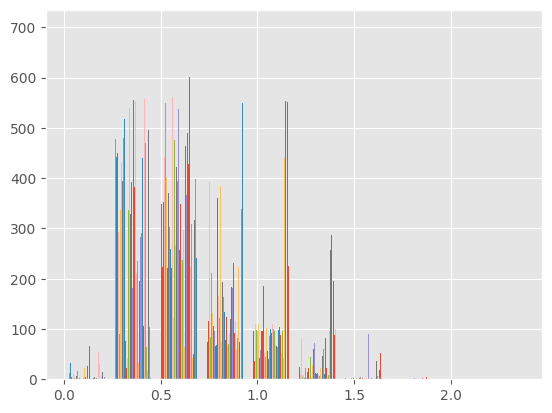

In [13]:
plt.hist(matrix_distance)

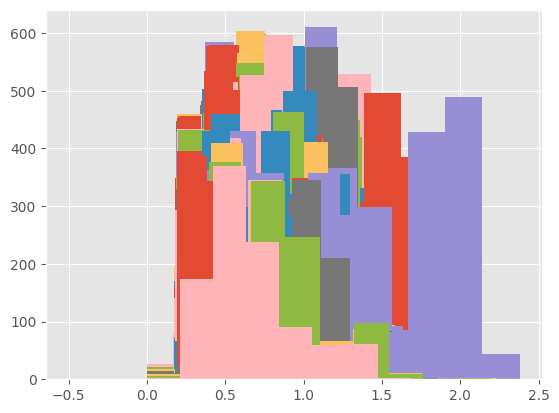

In [39]:
distributions = {}
distributions["0_15"] = sr.get_distribution(name="uniform", interval=[0,15])
distributions["5_20"] = sr.get_distribution(name="uniform", interval=[5,20])
distributions["10_25"] = sr.get_distribution(name="uniform", interval=[10,25])
distributions["10_30"] = sr.get_distribution(name="uniform", interval=[10,30])
distributions["15_30"] = sr.get_distribution(name="uniform", interval=[15,30])



NameError: name 'timer' is not defined

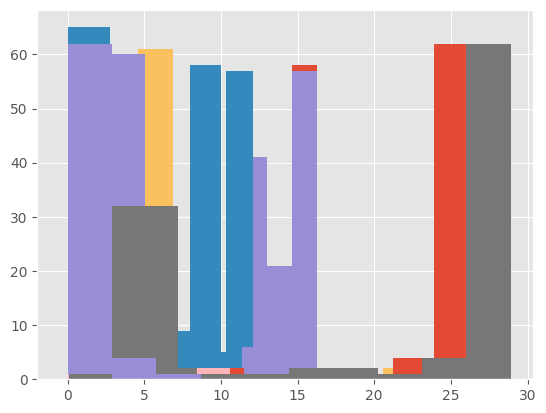

In [105]:
distance = sr.Distance(spatial.distance.pdist(Matrix_features, "euclidean"))
wisconsin_distances = distance.square_form()
i = 0
while i < len(wisconsin_distances):
    plt.hist(wisconsin_distances[i])
    i += 1

distributions = {}
distributions["0_15"] = sr.get_distribution(name="uniform", interval=[0,15])
distributions["5_20"] = sr.get_distribution(name="uniform", interval=[5,20])
distributions["10_25"] = sr.get_distribution(name="uniform", interval=[10,25])
distributions["10_30"] = sr.get_distribution(name="uniform", interval=[10,30])
distributions["15_30"] = sr.get_distribution(name="uniform", interval=[15,30])

probabilities = {}
for k in distributions.keys():
    probabilities[k] = distributions[k](wisconsin_distances)

number_instances=300
sample_size=30

start = timer()    
h0_sr = {}
h1_sr = {}
for k in  distributions.keys():
    h0_sr[k] = []
    h1_sr[k] = []
    for patient in wisconsin_distances:
        p = distributions[k](patient)
        s = sr.get_sample(number_instances, sample_size, p)
        f = distance.get_h0sr(sample=s,clustering_method="complete")
        b = distance.get_bc(sample=s, maxdim=1)
        g = sr.bc_to_sr(b,degree="H1")
        h0_sr[k].append(f)
        h1_sr[k].append(g)
end = timer()
print(timedelta(seconds=end-start))        

for k in distributions.keys():
    fig = plt.figure(k,figsize=(30,30))
    i = 0
    for f in h0_sr[k]:
        if classification[i] ==2:
            color = "black"
        else:
            color = "red"
        f.plot(color = color)
        i += 1
